In [2]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss, auc, roc_curve
import re
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from tqdm import tqdm
import optuna
RAND = 10

In [3]:
df = pd.read_excel('data.xlsx')

In [4]:
df

,text,class_name,class
0,уход ислам мамедов плотный удушающего реакция ...,martial_arts,1
1,ждать диллона прошлый неделя обещать конец нед...,basketball,3
2,энтони джошуа продолжать подготовка реванш уси...,martial_arts,1
3,мотогонка лёд speetokenoid tokenoid личный чем...,motosport,9
4,присылать ваш беговой фото публикация коммента...,athletics,6
...,...,...,...
47950,карлос алькараз прокомментировать победа четве...,tennis,2
47951,мотоспорт wsbk porttokenoid гонка ltokenoid на...,motosport,9
47952,кокорин пропустит матч специей иза негодования...,esport,0
47953,рафаэль надаль рассказать взаимоотношение фина...,tennis,2


# Анализ + доп. обработка данных

In [5]:
token_counter = Counter()

In [6]:
def remove_words_with_substring(text, substring):
    pattern = rf'\b\w*{re.escape(substring)}\w*\b'
    result = re.sub(pattern, '', text)
    return ' '.join(result.split())

In [7]:
df['text'] = df['text'].apply(lambda x: remove_words_with_substring(x, 'token'))

In [8]:
token_counter = Counter()
for one_string in df['text'].values:
    for token in one_string.split():
        token_counter[token] += 1

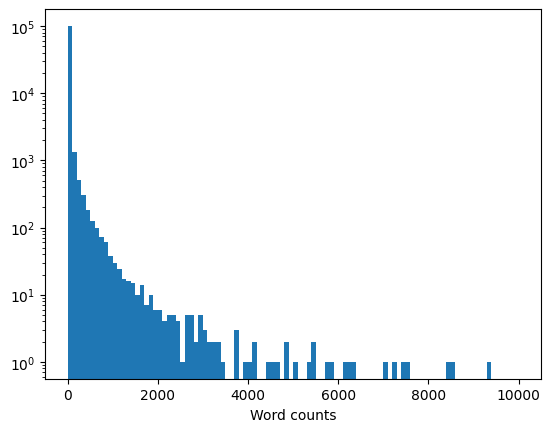

In [9]:
# Let's see how many words are there for each count
plt.hist(list(token_counter.values()), range=[0, 10**4], bins=100, log=True)
plt.xlabel("Word counts");

In [10]:
len(token_counter)

103484

In [11]:
# low_appearance = set([token for token,count in token_counter.items() if count < 3])
low_appearance = set()
to_del = set()
for i,v in token_counter.items():
    if len(i) == 1:
      to_del.add(i)

In [12]:
garbage = to_del.union(low_appearance)

In [13]:
def delete_garbage(text, garbage):
    return ' '.join([i for i in text.split() if i not in garbage])

df['text'] = df['text'].apply(lambda x: delete_garbage(x, garbage))

In [14]:
token_counter = Counter()
for one_string in df['text'].values:
    for token in one_string.split():
        token_counter[token] += 1

total_words = 0
for i in token_counter.values():
    total_words += i
print(f'Слов после удаления единичных токенов: {total_words}')

Слов после удаления единичных токенов: 1855889


In [15]:
dict_labels = {0:'esport', 1:'martial_arts', 2:'tennis', 3:'basketball',
        4:'volleyball', 5:'boardgames', 6:'athletics', 7:'winter_sport',
        8:'football', 9:'motosport', 10:'autosport', 11:'extreme', 12:'hockey'}

Зависимость метки класса от количество токенов в тексте

In [16]:
df_ = df.copy()

In [17]:
def add_len(text):
    return len(text.split())
df_['length'] = df_['text'].apply(add_len)

C:\Users\albin\AppData\Local\Temp\ipykernel_18412\4077276993.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha='right')


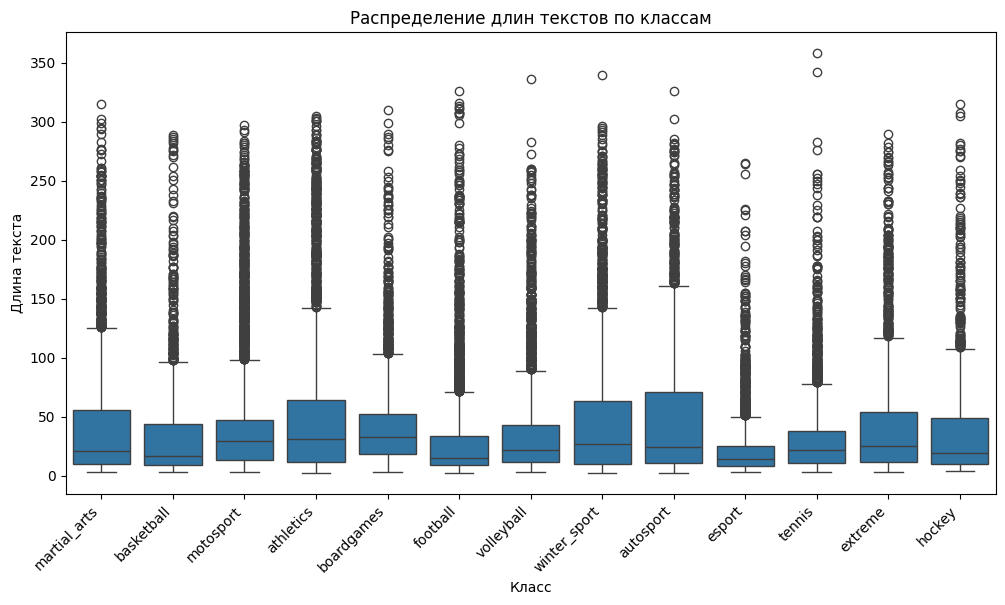

In [64]:
# Создание ящиковой диаграммы
plt.figure(figsize=(12, 6))
barplot = sns.boxplot(x='class_name', y='length', data=df_)
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha='right')

# Настройка заголовка и меток осей
plt.title('Распределение длин текстов по классам')
plt.xlabel('Класс')
plt.ylabel('Длина текста')

# Показать график
plt.show()

In [19]:
most_comm = dict()
all_labels_encoded = sorted(df_['class'].unique())

In [21]:
for i in all_labels_encoded:
    tok_con = Counter()
    for one_string in df[df['class'] == i]['text'].values:
        for token in one_string.split():
            tok_con[token] += 1
    most_comm[dict_labels[i]] = tok_con.most_common(5)

In [22]:
for i,v in most_comm.items():
    print('Класс:', i)
    print('Самые популярные слова:', v)
    print()

Класс: esport
Самые популярные слова: [('команда', 892), ('это', 789), ('свой', 709), ('турнир', 675), ('игра', 620)]

Класс: martial_arts
Самые популярные слова: [('бой', 2504), ('это', 2364), ('свой', 1204), ('ufc', 1189), ('чемпион', 1038)]

Класс: tennis
Самые популярные слова: [('турнир', 2281), ('это', 1802), ('матч', 1440), ('первый', 1051), ('медведев', 936)]

Класс: basketball
Самые популярные слова: [('матч', 1254), ('это', 1251), ('команда', 1093), ('игра', 988), ('сезон', 977)]

Класс: volleyball
Самые популярные слова: [('матч', 1886), ('волейбол', 1834), ('команда', 1737), ('динамо', 1134), ('россия', 1055)]

Класс: boardgames
Самые популярные слова: [('игра', 2993), ('это', 1457), ('новый', 1175), ('свой', 903), ('весь', 750)]

Класс: athletics
Самые популярные слова: [('бег', 4062), ('это', 2212), ('забег', 1949), ('спорт', 1820), ('весь', 1469)]

Класс: winter_sport
Самые популярные слова: [('это', 2337), ('россия', 1666), ('год', 1326), ('мир', 1119), ('весь', 1067)]


In [65]:
proportions = df['class_name'].value_counts().sort_index().mul(100) / df.shape[0]
proportions

class_name
athletics       8.247315
autosport       6.307997
basketball      7.661349
boardgames      7.344385
esport          8.241059
extreme         5.863831
football        8.737358
hockey          3.830675
martial_arts    8.468356
motosport       7.949119
tennis          9.241998
volleyball      8.939631
winter_sport    9.166927
Name: count, dtype: float64

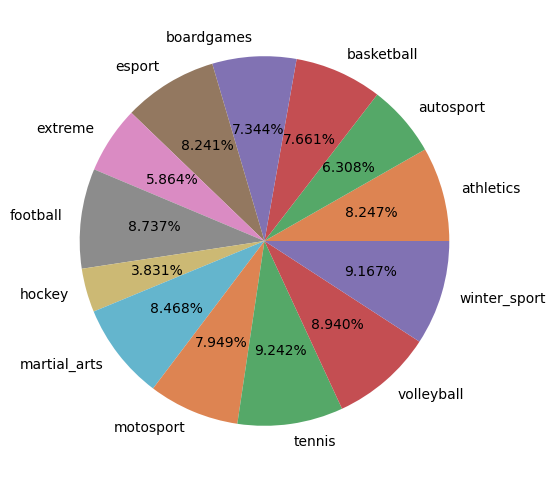

In [68]:
plt.figure(figsize=(12, 6))
colors = sns.color_palette('deep')[1:12]
plt.pie(proportions, labels = proportions.index, colors = colors, autopct='%.3f%%')
plt.show()
plt.show()

# Лог рекгрессия + тюннинг

In [21]:
X = df.drop(columns=['class_name', 'class'], axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RAND)

In [20]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train['text'])
X_test_tfidf = vectorizer.transform(X_test['text'])

In [21]:
LogReg = LogisticRegression(multi_class='multinomial', class_weight='balanced', random_state=RAND, solver='saga')
LogReg.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   random_state=10, solver='saga')

In [22]:
def get_metrics_multiclass(y_test, y_pred, y_prob, name):
    """
    y_test - метки класса без бинаризации
    y_prob - предсказанные вероятности классов
    name - название модели/подхода
    """
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    df_metrics['Precision_micro'] = precision_score(y_test,
                                                    y_pred,
                                                    average='micro')
    df_metrics['Precision_macro'] = precision_score(y_test,
                                                    y_pred,
                                                    average='macro')
    df_metrics['Recall_micro'] = recall_score(y_test, y_pred, average='micro')
    df_metrics['Recall_macro'] = recall_score(y_test, y_pred, average='macro')
    df_metrics['F1_micro'] = f1_score(y_test, y_pred, average='micro')
    df_metrics['F1_macro'] = f1_score(y_test, y_pred, average='macro')
    df_metrics['Logloss'] = log_loss(y_test, y_prob)

    return df_metrics

In [23]:
model = get_metrics_multiclass(y_test, LogReg.predict(X_test_tfidf), LogReg.predict_proba(X_test_tfidf), 'LR_Base')
model

,model,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,LR_Base,0.826713,0.828805,0.826713,0.822981,0.826713,0.823412,0.753425


In [23]:
X_val = X_train_tfidf[:13000]
y_val = y_train[:13000]

In [24]:
def objective(trial, RANDOM):
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', 'none'])
    C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    l1_ratio = None
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)

    # Создание модели логистической регрессии
    model = LogisticRegression(
        solver='saga',
        penalty=penalty,
        C=C,
        l1_ratio=l1_ratio,
        random_state=RANDOM,
        multi_class='multinomial',
        class_weight='balanced'
    )

    # Кросс-валидация
    score = cross_val_score(model, X_val, y_val, cv=3, scoring='accuracy').mean()

    return score

In [25]:
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# study.optimize(objective, n_trials=15)
pointer = lambda trial: objective(trial, RAND)
study.optimize(pointer, n_trials=20, show_progress_bar=True)

[I 2024-07-26 21:44:50,300] A new study created in memory with name: LogisticRegression


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-07-26 21:44:50,808] Trial 0 finished with value: 0.06123260413379567 and parameters: {'penalty': 'elasticnet', 'C': 0.0017896644087879465, 'l1_ratio': 0.38426471800103834}. Best is trial 0 with value: 0.06123260413379567.
[I 2024-07-26 21:46:31,493] Trial 1 finished with value: 0.7855384175837176 and parameters: {'penalty': 'elasticnet', 'C': 5.671295115370521, 'l1_ratio': 0.44318422848426575}. Best is trial 1 with value: 0.7855384175837176.


C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib

[I 2024-07-26 21:46:36,508] Trial 2 finished with value: 0.7825388258008417 and parameters: {'penalty': 'none', 'C': 0.03516390588892601}. Best is trial 1 with value: 0.7855384175837176.
[I 2024-07-26 21:46:40,600] Trial 3 finished with value: 0.7900002637666956 and parameters: {'penalty': 'l2', 'C': 14.211639755261055}. Best is trial 3 with value: 0.7900002637666956.
[I 2024-07-26 21:46:40,711] Trial 4 finished with value: 0.07292158677642059 and parameters: {'penalty': 'l1', 'C': 2.1358603878913066e-05}. Best is trial 3 with value: 0.7900002637666956.


C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib

[I 2024-07-26 21:46:45,700] Trial 5 finished with value: 0.7825388258008417 and parameters: {'penalty': 'none', 'C': 0.8378526538940618}. Best is trial 3 with value: 0.7900002637666956.


C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2024-07-26 21:48:22,444] Trial 6 finished with value: 0.7743847251322057 and parameters: {'penalty': 'l1', 'C': 35.498588759596046}. Best is trial 3 with value: 0.7900002637666956.
[I 2024-07-26 21:48:23,400] Trial 7 finished with value: 0.29023101525008155 and parameters: {'penalty': 'elasticnet', 'C': 0.030719433641148625, 'l1_ratio': 0.633167639753993}. Best is trial 3 with value: 0.7900002637666956.
[I 2024-07-26 21:48:24,588] Trial 8 finished with value: 0.7191540380817338 and parameters: {'penalty': 'l2', 'C': 0.0017556638185833107}. Best is trial 3 with value: 0.7900002637666956.
[I 2024-07-26 21:48:25,028] Trial 9 finished with value: 0.07138723141281714 and parameters: {'penalty': 'l1', 'C': 0.005569924240911751}. Best is trial 3 with value: 0.7900002637666956.
[I 2024-07-26 21:48:26,272] Trial 10 finished with value: 0.7870766957225385 and parameters: {'penalty': 'l2', 'C': 1.182411520295275}. Best is trial 3 with value: 0.7900002637666956.
[I 2024-07-26 21:48:27,416] Tria

C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2024-07-26 21:48:32,337] Trial 12 finished with value: 0.7853848968468095 and parameters: {'penalty': 'l2', 'C': 63.35033576533648}. Best is trial 3 with value: 0.7900002637666956.
[I 2024-07-26 21:48:33,597] Trial 13 finished with value: 0.7866151395054244 and parameters: {'penalty': 'l2', 'C': 1.1403091006918196}. Best is trial 3 with value: 0.7900002637666956.
[I 2024-07-26 21:48:36,422] Trial 14 finished with value: 0.7918462578836688 and parameters: {'penalty': 'l2', 'C': 7.4310179483581456}. Best is trial 14 with value: 0.7918462578836688.


C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2024-07-26 21:48:41,525] Trial 15 finished with value: 0.7843848554180429 and parameters: {'penalty': 'l2', 'C': 80.13329084375782}. Best is trial 14 with value: 0.7918462578836688.
[I 2024-07-26 21:48:45,329] Trial 16 finished with value: 0.7909233052004675 and parameters: {'penalty': 'l2', 'C': 11.459592046415752}. Best is trial 14 with value: 0.7918462578836688.
[I 2024-07-26 21:48:46,232] Trial 17 finished with value: 0.7403077543183986 and parameters: {'penalty': 'l2', 'C': 0.10420590639127571}. Best is trial 14 with value: 0.7918462578836688.


C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib

[I 2024-07-26 21:48:51,204] Trial 18 finished with value: 0.7825388258008417 and parameters: {'penalty': 'none', 'C': 5.25318050770859}. Best is trial 14 with value: 0.7918462578836688.
[I 2024-07-26 21:48:53,988] Trial 19 finished with value: 0.44892255564864897 and parameters: {'penalty': 'l2', 'C': 3.0157052019885286e-05}. Best is trial 14 with value: 0.7918462578836688.


In [26]:
study.optimize(pointer, n_trials=15, show_progress_bar=True)

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-07-26 21:50:00,940] Trial 20 finished with value: 0.7478462632797035 and parameters: {'penalty': 'l2', 'C': 0.15341788278628432}. Best is trial 14 with value: 0.7918462578836688.
[I 2024-07-26 21:50:02,781] Trial 21 finished with value: 0.7926922283219898 and parameters: {'penalty': 'l2', 'C': 4.1684331763768085}. Best is trial 21 with value: 0.7926922283219898.
[I 2024-07-26 21:50:04,758] Trial 22 finished with value: 0.7923076365996419 and parameters: {'penalty': 'l2', 'C': 4.846123912011181}. Best is trial 21 with value: 0.7926922283219898.
[I 2024-07-26 21:50:06,513] Trial 23 finished with value: 0.7920767963656855 and parameters: {'penalty': 'l2', 'C': 3.8607316781413217}. Best is trial 21 with value: 0.7926922283219898.
[I 2024-07-26 21:50:07,484] Trial 24 finished with value: 0.7713076541012543 and parameters: {'penalty': 'l2', 'C': 0.43965095745498445}. Best is trial 21 with value: 0.7926922283219898.
[I 2024-07-26 21:50:09,141] Trial 25 finished with value: 0.792076814

C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib

[I 2024-07-26 21:50:13,939] Trial 26 finished with value: 0.7825388258008417 and parameters: {'penalty': 'none', 'C': 31.715323960337848}. Best is trial 21 with value: 0.7926922283219898.
[I 2024-07-26 21:50:17,122] Trial 27 finished with value: 0.5535392076767965 and parameters: {'penalty': 'l1', 'C': 0.19336631548289304}. Best is trial 21 with value: 0.7926922283219898.


C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2024-07-26 21:50:44,682] Trial 28 finished with value: 0.7590004882346385 and parameters: {'penalty': 'elasticnet', 'C': 2.4376356211667574, 'l1_ratio': 0.9932397323534041}. Best is trial 21 with value: 0.7926922283219898.
[I 2024-07-26 21:50:46,542] Trial 29 finished with value: 0.08853595390337966 and parameters: {'penalty': 'elasticnet', 'C': 0.00039729225486009336, 'l1_ratio': 0.02131495659672744}. Best is trial 21 with value: 0.7926922283219898.


C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2024-07-26 21:50:51,432] Trial 30 finished with value: 0.787923269664739 and parameters: {'penalty': 'l2', 'C': 22.33529596709705}. Best is trial 21 with value: 0.7926922283219898.
[I 2024-07-26 21:50:52,956] Trial 31 finished with value: 0.791461524160408 and parameters: {'penalty': 'l2', 'C': 2.7774206050338397}. Best is trial 21 with value: 0.7926922283219898.
[I 2024-07-26 21:50:54,653] Trial 32 finished with value: 0.7923844590934953 and parameters: {'penalty': 'l2', 'C': 3.477467396323428}. Best is trial 21 with value: 0.7926922283219898.
[I 2024-07-26 21:50:55,593] Trial 33 finished with value: 0.7700769321895585 and parameters: {'penalty': 'l2', 'C': 0.4173825106763882}. Best is trial 21 with value: 0.7926922283219898.
[I 2024-07-26 21:50:56,479] Trial 34 finished with value: 0.7326154938687024 and parameters: {'penalty': 'l2', 'C': 0.04181792073609134}. Best is trial 21 with value: 0.7926922283219898.


In [27]:
study.best_params

{'penalty': 'l2', 'C': 4.1684331763768085}

In [29]:
LogReg_tuned = LogisticRegression(multi_class='multinomial', class_weight='balanced', random_state=RAND, solver='saga', **study.best_params)
LogReg_tuned.fit(X_train_tfidf, y_train)

LogisticRegression(C=4.1684331763768085, class_weight='balanced',
                   multi_class='multinomial', random_state=10, solver='saga')

In [50]:
# model = pd.concat([model, get_metrics_multiclass(y_train, LogReg_tuned.predict(X_train_tfidf), LogReg_tuned.predict_proba(X_train_tfidf), 'lr_tuned_Opt_train')])
model = pd.concat([model, get_metrics_multiclass(y_test, LogReg_tuned.predict(X_test_tfidf), LogReg_tuned.predict_proba(X_test_tfidf), 'LR_tuned_optuna')])
model

,model,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,LR_Base,0.826713,0.828805,0.826713,0.822981,0.826713,0.823412,0.753425
0,LR_tuned_optuna,0.831404,0.828572,0.831404,0.826992,0.831404,0.826684,0.623931


In [32]:
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-5, 2, 100),
    'l1_ratio': np.linspace(0, 1, 100)
}

In [33]:
lg = LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='saga', random_state=RAND)

# Создание RandomizedSearchCV
random_search = RandomizedSearchCV(
    lg,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='accuracy',
    cv=3,
    random_state=RAND,
    n_jobs=-1
)

# Запуск поиска
random_search.fit(X_val, y_val)

C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(class_weight='balanced',
                                                multi_class='multinomial',
                                                random_state=10,
                                                solver='saga'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-05, 1.17681195e-05, 1.38488637e-05, 1.62975083e-05,
       1.91791026e-05, 2.25701972e-05, 2.65608778e-05, 3.12571585e-05,
       3.67837977e-05, 4.32876128e-05, 5.09413801e-0...
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747475,
       0.75757576, 0.76767677, 0.77777778, 0.78787879, 0.7979798 ,
       0.80808081, 0.81818182, 0.82828283, 0.83838384, 0.84848485,
       0.85858586, 0.86868687, 0.87878788, 0.88888889, 0.8989899 ,
       0.90909091, 0.91919192, 0.92929293, 0.93939394, 0.94949495,
       0.95959596, 0.96969697, 0.97979798, 0.98989899, 1.        ]),
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none']},
                   random_state=10, scoring='accuracy')

In [36]:
random_search.best_estimator_

LogisticRegression(C=4.534878508128582, class_weight='balanced',
                   l1_ratio=0.7272727272727273, multi_class='multinomial',
                   random_state=10, solver='saga')

In [37]:
random_search.best_params_

{'penalty': 'l2', 'l1_ratio': 0.7272727272727273, 'C': 4.534878508128582}

In [24]:
LogReg_tuned_RS = LogisticRegression(multi_class='multinomial', class_weight='balanced', random_state=RAND, solver='saga', **random_search.best_params_)
LogReg_tuned_RS.fit(X_train_tfidf, y_train)

C:\Users\albin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


LogisticRegression(C=4.534878508128582, class_weight='balanced',
                   l1_ratio=0.7272727272727273, multi_class='multinomial',
                   random_state=10, solver='saga')

In [53]:
model = pd.concat([model, get_metrics_multiclass(y_test, LogReg_tuned_RS.predict(X_test_tfidf), LogReg_tuned_RS.predict_proba(X_test_tfidf), 'LR_tuned_RandSear')])
model

,model,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,LR_Base,0.826713,0.828805,0.826713,0.822981,0.826713,0.823412,0.753425
0,LR_tuned_optuna,0.831404,0.828572,0.831404,0.826992,0.831404,0.826684,0.623931
0,LR_tuned_RandSear,0.830570,0.827685,0.830570,0.825900,0.830570,0.825739,0.620994


Лучшие параметры:
LogisticRegression(C=4.1684331763768085, class_weight='balanced',  multi_class='multinomial', random_state=10, solver='saga')

In [25]:
get_metrics_multiclass(y_test, LogReg_tuned_RS.predict(X_test_tfidf), LogReg_tuned_RS.predict_proba(X_test_tfidf), 'LR_tuned_RandSear')

,model,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,LR_tuned_RandSear,0.83057,0.827685,0.83057,0.8259,0.83057,0.825739,0.620994


In [46]:
y_test_ = y_test
y_pred_ = pd.Series(LogReg_tuned_RS.predict(X_test_tfidf))
# y_test_ = y_test_.value_counts().sort_index()
# y_pred_ = y_pred_.value_counts().sort_index()

In [47]:
y_test_

26869     0
11521     3
22360     8
43489    10
4725      6
         ..
2375     10
40377     4
33276     8
36534     3
16865     7
Name: class, Length: 9591, dtype: int64

In [48]:
y_pred_

0        0
1        3
2        8
3       10
4        6
        ..
9586    10
9587     4
9588     0
9589     3
9590     7
Length: 9591, dtype: int64

In [55]:
accuracy_lr = dict()
for i,v in enumerate(y_test_):
    if v == y_pred_[i]:
        accuracy_lr[v] = accuracy_lr.get(v, 0) + 1
accuracy_lr = pd.Series(accuracy_lr).sort_index()/y_test_.value_counts().sort_index()

In [56]:
accuracy_lr

0     0.772440
1     0.786946
2     0.941375
3     0.820408
4     0.838973
5     0.923295
6     0.836915
7     0.858931
8     0.780430
9     0.854331
10    0.814876
11    0.717584
12    0.790191
dtype: float64

In [57]:
dict_labels = {0:'esport', 1:'martial_arts', 2:'tennis', 3:'basketball',
        4:'volleyball', 5:'boardgames', 6:'athletics', 7:'winter_sport',
        8:'football', 9:'motosport', 10:'autosport', 11:'extreme', 12:'hockey'}
my_res = pd.DataFrame(accuracy_lr).reset_index()
my_res['index'] = my_res['index'].map(dict_labels)
my_res.rename(columns={'index': 'class', 0: 'proportion'}, inplace=True)
my_res

,class,proportion
0,esport,0.772440
1,martial_arts,0.786946
2,tennis,0.941375
3,basketball,0.820408
4,volleyball,0.838973
5,boardgames,0.923295
6,athletics,0.836915
7,winter_sport,0.858931
8,football,0.780430
9,motosport,0.854331


C:\Users\albin\AppData\Local\Temp\ipykernel_17908\3291314698.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha='right')


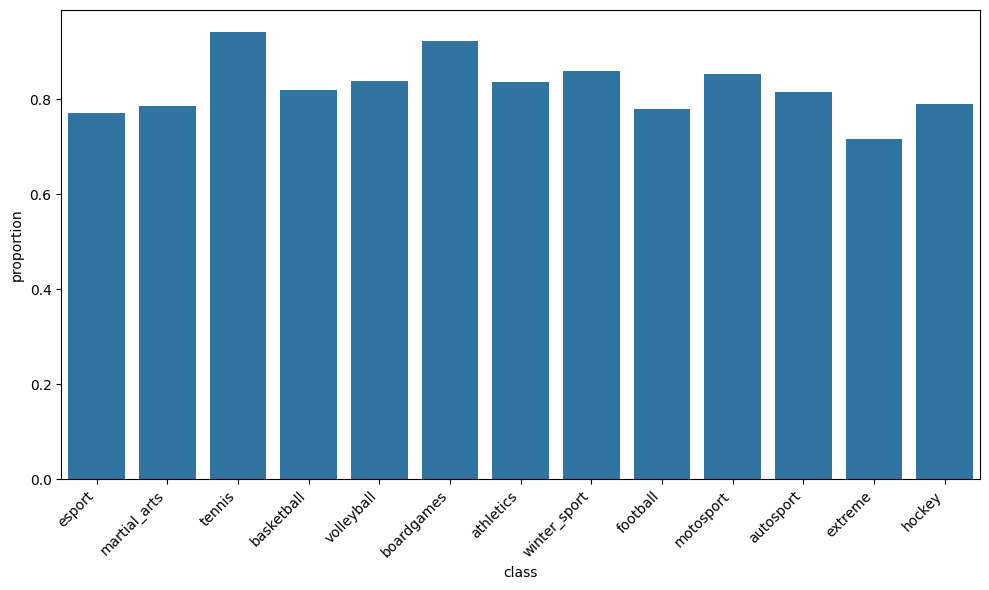

In [58]:
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='class', y='proportion', data=my_res)
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()